In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [24]:
from funcs import SVM
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
import itertools
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import time

In [4]:
df = pd.read_csv('data/Letters_Q_O.csv')
columns = list(df.columns[:-1])

In [5]:
df[columns] = preprocessing.StandardScaler().fit_transform(df[columns])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1939671)

In [6]:
def process_df(df):
    X = np.array(df.drop(['letter'], axis=1))
    y_letter = np.array(df[['letter']])

    y = []
    for i in y_letter:
        if i[0] == 'Q':
            y.append(-1)
        else:
            y.append(1)
    y = np.array(y)
    return X, y

In [31]:
grid_C = [1, 5, 10, 20, 30, 40, 50]
grid_gamma = [1, 2, 3, 4, 5]
grid_kernel = ['polynomial']

iterables = [grid_C, grid_gamma, grid_kernel]
min_loss = 1000
k_fold = 5

kf5 = KFold(n_splits=k_fold, shuffle=False)

list_ = [['C', 'Gamma', 'Kernel', 'Validation Loss']]

for t in itertools.product(*iterables):
    
    val_loss = 0
    val_loss_sklearn = 0
    
    C = t[0]
    gamma = t[1]
    kernel = t[2]
    
    print('C: ', C)
    print('gamma: ', gamma)
    print('kernel: ', kernel)
    
    for train_index, test_index in kf5.split(train_df):
        
        X_, y_ = process_df(train_df.iloc[train_index])
        X_val, y_val = process_df(train_df.iloc[test_index])

        svm = SVM(X_, y_, C=C, gamma=gamma, kernel=kernel)
        svm.fit(tol=1e-5, fix_intercept=False)
        
        val_loss += svm.eval(X_val, y_val)
        
        # sklearn implementation
        clf = SVC(kernel = 'poly', degree=gamma, C=C)
        clf.fit(X_, y_)
        val_loss_sklearn += clf.score(X_val, y_val)
        
    val_loss = val_loss/k_fold
    val_loss_sklearn = val_loss_sklearn/k_fold
    print('Accuracy: ', val_loss)
    print('Accuracy Sklearn: ', val_loss_sklearn)
    print('=======================')
    print('')
    
    list_.append([C, gamma, kernel, val_loss])

C:  1
gamma:  1
kernel:  polynomial
Accuracy:  0.967219516475802
Accuracy Sklearn:  0.9634855864156904

C:  1
gamma:  2
kernel:  polynomial
Accuracy:  0.9812557588521784
Accuracy Sklearn:  0.8604887894344259

C:  1
gamma:  3
kernel:  polynomial
Accuracy:  0.9831380808213768
Accuracy Sklearn:  0.9728401562020095

C:  1
gamma:  4
kernel:  polynomial
Accuracy:  0.904444736957571
Accuracy Sklearn:  0.8183405730332147

C:  1
gamma:  5
kernel:  polynomial
Accuracy:  0.8707823263568952
Accuracy Sklearn:  0.8286165591680927

C:  5
gamma:  1
kernel:  polynomial
Accuracy:  0.9672107410820061
Accuracy Sklearn:  0.9634724233249967

C:  5
gamma:  2
kernel:  polynomial
Accuracy:  0.9812557588521784
Accuracy Sklearn:  0.9101092536527577

C:  5
gamma:  3
kernel:  polynomial
Accuracy:  0.9831380808213768
Accuracy Sklearn:  0.9812689219428721

C:  5
gamma:  4
kernel:  polynomial
Accuracy:  0.904444736957571
Accuracy Sklearn:  0.9091702865166076

C:  5
gamma:  5
kernel:  polynomial


KeyboardInterrupt: 

In [31]:
grid_C = [5]
grid_gamma = [0.01, 0.05, 0.1, 0.13, 0.15, 0.2]
grid_kernel = ['rbf']

iterables = [grid_C, grid_gamma, grid_kernel]
min_acc = 0
k_fold = 5

kf5 = KFold(n_splits=k_fold, shuffle=False)

for t in itertools.product(*iterables):
    
    val_loss = 0
    val_loss_sklearn = 0
    
    C = t[0]
    gamma = t[1]
    kernel = t[2]
    
    print('C: ', C)
    print('gamma: ', gamma)
    print('kernel: ', kernel)
    
    for train_index, test_index in kf5.split(train_df):
        
        X_, y_ = process_df(train_df.iloc[train_index])
        X_val, y_val = process_df(train_df.iloc[test_index])
        
        start = time.time()
        
        svm = SVM(X_, y_, C=C, gamma=gamma, kernel=kernel)
        svm.fit(tol=1e-5, fix_intercept=False)
        
        stop = time.time()
        
        val_loss += svm.eval(X_val, y_val)
        
    val_loss = val_loss/k_fold
    print('Accuracy: ', val_loss)
    print('=======================')
    print('')
    if val_loss > min_acc:
        print('inside')
        X, y = process_df(train_df)
        X_test, y_test = process_df(test_df)
        val_acc = val_loss
        train_acc = svm.eval(X, y)
        test_acc = svm.eval(X_test, y_test)
        best_time = round((stop-start), 2)
        num_it = svm.fit_sol['iterations']
        min_acc = val_loss
        KKT = svm.fit_sol['status']
        
        

C:  5
gamma:  0.01
kernel:  rbf
Accuracy:  0.977526216488965

inside
C:  5
gamma:  0.05
kernel:  rbf
Accuracy:  0.9859505945329297

inside
C:  5
gamma:  0.1
kernel:  rbf
Accuracy:  0.98782852880523

inside
C:  5
gamma:  0.13
kernel:  rbf
Accuracy:  0.9887674959413804

inside
C:  5
gamma:  0.15
kernel:  rbf
Accuracy:  0.9915756219560354

inside
C:  5
gamma:  0.2
kernel:  rbf
Accuracy:  0.9868983370628758



## MultiClass SVM

In [44]:
def convert_labels(list_, dict_):
    """
    List contains the predictions e.g. [-1, 1, 1, -1, ...]
    Dictionary contains the relation, e.g. {'-1': 'Q', '1': 'D'}
    """
    
    l = [dict_[i] for i in list_]
    
    return l

In [45]:
def voting(list_):
    """
    list_ is a list of lists
    """
    best = []
    l = list(map(list, zip(*list_)))
    for i in l:
        t = {'Q':0, 'O':0, 'D':0}
        for j in i:
            t[j] += 1
        best.append(max(t, key=t.get))
    return best

In [46]:
import copy

def process_df(df, letters=['Q', 'O'], test=False):
    df = df.copy()
    if test:
        X = np.array(df.drop(['letter'], axis=1))
        y_letter = np.array(df[['letter']])
        return X, np.array(y_letter)
    else:
        df = df[df.letter.isin(letters)]
        X = np.array(df.drop(['letter'], axis=1))
        y_letter = np.array(df[['letter']])

        y = []
        for i in y_letter:
            if i[0] == letters[0]:
                y.append(-1)
            else:
                y.append(1)
        y = np.array(y)
        return X, y

In [47]:
df_Q_O = pd.read_csv('data/Letters_Q_O.csv')
df_D = pd.read_csv('data/Letter_D.csv')
df = pd.concat([df_D, df_Q_O])

columns = list(df.columns[:-1])

df[columns] = preprocessing.StandardScaler().fit_transform(df[columns])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1939671)

In [48]:
C = 5
gamma = 0.15
kernel = 'rbf'

X_Q_O, y_Q_O = process_df(train_df, ['Q', 'O'])
X_Q_D, y_Q_D = process_df(train_df, ['Q', 'D'])
X_D_O, y_D_O = process_df(train_df, ['D', 'O'])

X_test, y_test = process_df(test_df, test=True)
X_train, y_train = process_df(train_df, test=True)

In [49]:
SVM_Q_O = SVM(X_Q_O, y_Q_O, C=C, gamma=gamma, kernel=kernel)
SVM_Q_O.fit(tol=1e-5, fix_intercept=False)

SVM_Q_D = SVM(X_Q_D, y_Q_D, C=C, gamma=gamma, kernel=kernel)
SVM_Q_D.fit(tol=1e-5, fix_intercept=False)

SVM_D_O = SVM(X_D_O, y_D_O, C=C, gamma=gamma, kernel=kernel)
SVM_D_O.fit(tol=1e-5, fix_intercept=False)

In [136]:
l1 = convert_labels(SVM_Q_O.pred(X_test), {-1: 'Q', 1: 'O'})
l2 = convert_labels(SVM_Q_D.pred(X_test), {-1: 'Q', 1: 'D'})
l3 = convert_labels(SVM_D_O.pred(X_test), {-1: 'D', 1: 'O'})

l = [l1, l2, l3]
l = voting(l)

y_test = [item for sublist in y_test for item in sublist]

print('Accuracy: ', sum(np.array(y_test) == np.array(l))/len(y_test))

Accuracy:  0.9901960784313726


In [50]:
l1 = convert_labels(SVM_Q_O.pred(X_train), {-1: 'Q', 1: 'O'})
l2 = convert_labels(SVM_Q_D.pred(X_train), {-1: 'Q', 1: 'D'})
l3 = convert_labels(SVM_D_O.pred(X_train), {-1: 'D', 1: 'O'})

l = [l1, l2, l3]
l = voting(l)

y_train = [item for sublist in y_train for item in sublist]

print('Accuracy: ', sum(np.array(y_train) == np.array(l))/len(y_train))

Accuracy:  1.0


## Over/Underfitting

In [13]:
grid_C = [5]
grid_gamma = np.linspace(0.001, 0.99, 100)
grid_kernel = ['rbf']

iterables = [grid_C, grid_gamma, grid_kernel]
min_loss = 1000

list_val = []
list_train = []

for t in itertools.product(*iterables):
       
    C = t[0]
    gamma = t[1]
    kernel = t[2]
    
    print('C: ', C)
    print('gamma: ', gamma)
    print('kernel: ', kernel)
    
    X_, y_ = process_df(train_df)
    X_val, y_val = process_df(test_df)

    svm = SVM(X_, y_, C=C, gamma=gamma, kernel=kernel)
    svm.fit(tol=1e-5, fix_intercept=False)
       
    train_loss = svm.eval(X_, y_)
    val_loss = svm.eval(X_val, y_val)
    
    list_val.append(val_loss)
    list_train.append(train_loss)

C:  5
gamma:  0.001
kernel:  rbf
C:  5
gamma:  0.01098989898989899
kernel:  rbf
C:  5
gamma:  0.02097979797979798
kernel:  rbf
C:  5
gamma:  0.03096969696969697
kernel:  rbf
C:  5
gamma:  0.04095959595959596
kernel:  rbf
C:  5
gamma:  0.05094949494949495
kernel:  rbf
C:  5
gamma:  0.06093939393939394
kernel:  rbf
C:  5
gamma:  0.07092929292929293
kernel:  rbf
C:  5
gamma:  0.08091919191919192
kernel:  rbf
C:  5
gamma:  0.09090909090909091
kernel:  rbf
C:  5
gamma:  0.1008989898989899
kernel:  rbf
C:  5
gamma:  0.11088888888888888
kernel:  rbf
C:  5
gamma:  0.12087878787878788
kernel:  rbf
C:  5
gamma:  0.13086868686868686
kernel:  rbf
C:  5
gamma:  0.14085858585858585
kernel:  rbf
C:  5
gamma:  0.15084848484848484
kernel:  rbf
C:  5
gamma:  0.16083838383838384
kernel:  rbf
C:  5
gamma:  0.17082828282828283
kernel:  rbf
C:  5
gamma:  0.18081818181818182
kernel:  rbf
C:  5
gamma:  0.19080808080808082
kernel:  rbf
C:  5
gamma:  0.2007979797979798
kernel:  rbf
C:  5
gamma:  0.2107878787878

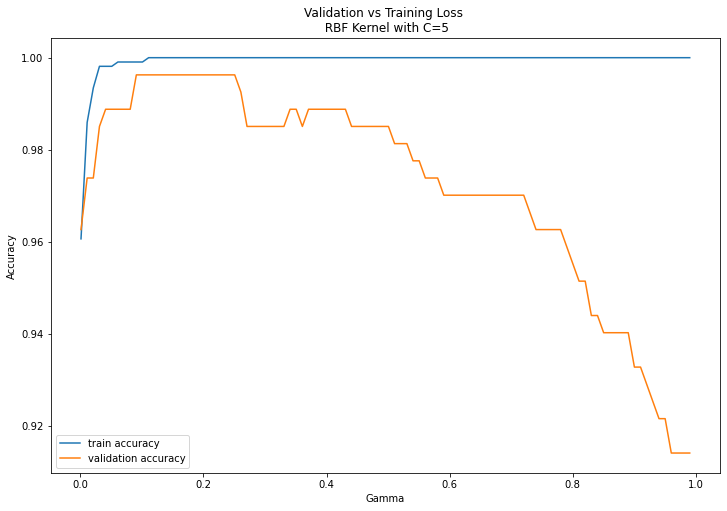

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(grid_gamma, list_train)
plt.plot(grid_gamma, list_val)
plt.title('Validation vs Training Loss \n RBF Kernel with C=5')
plt.ylabel('Accuracy')
plt.xlabel('Gamma')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower left')
plt.show()

In [20]:
grid_C = np.linspace(1, len(train_df), 100)
grid_gamma = [0.1]
grid_kernel = ['rbf']

iterables = [grid_C, grid_gamma, grid_kernel]
min_loss = 1000

list_val = []
list_train = []

for t in itertools.product(*iterables):
       
    C = t[0]
    gamma = t[1]
    kernel = t[2]
    
    print('C: ', C)
    print('gamma: ', gamma)
    print('kernel: ', kernel)
    
    X_, y_ = process_df(train_df)
    X_val, y_val = process_df(test_df)

    svm = SVM(X_, y_, C=C, gamma=gamma, kernel=kernel)
    svm.fit(tol=1e-5, fix_intercept=False)
       
    train_loss = svm.eval(X_, y_)
    val_loss = svm.eval(X_val, y_val)
    
    list_val.append(val_loss)
    list_train.append(train_loss)

C:  1.0
gamma:  0.1
kernel:  rbf
-0.2698239429573493
C:  11.777777777777779
gamma:  0.1
kernel:  rbf
-0.2641490821349956
C:  22.555555555555557
gamma:  0.1
kernel:  rbf
-0.2873480271963881
C:  33.333333333333336
gamma:  0.1
kernel:  rbf
-0.29356938322826304
C:  44.111111111111114
gamma:  0.1
kernel:  rbf
-0.2935117268696799
C:  54.88888888888889
gamma:  0.1
kernel:  rbf
-0.29319630742123587
C:  65.66666666666667
gamma:  0.1
kernel:  rbf
-0.29369645033955843
C:  76.44444444444446
gamma:  0.1
kernel:  rbf
-0.2936216637740889
C:  87.22222222222223
gamma:  0.1
kernel:  rbf
-0.2935691578190651
C:  98.0
gamma:  0.1
kernel:  rbf
-0.2935697797827106
C:  108.77777777777779
gamma:  0.1
kernel:  rbf


KeyboardInterrupt: 

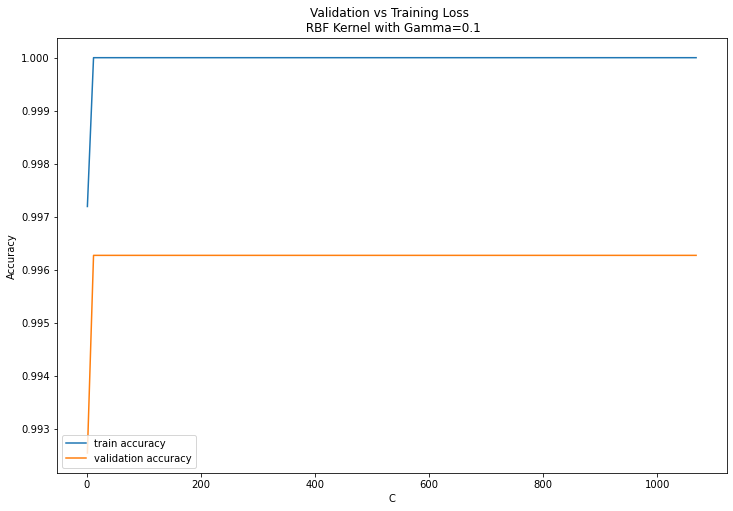

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(grid_C, list_train)
plt.plot(grid_C, list_val)
plt.title('Validation vs Training Loss \n RBF Kernel with Gamma=0.1')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower left')
plt.show()

In [26]:
svm.fit_sol['iterations']

{'x': <855x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <1710x1 matrix, tc='d'>,
 'z': <1710x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 2.8634821864599725e-06,
 'relative gap': 1.4619271752160697e-08,
 'primal objective': -195.87037131564068,
 'dual objective': -195.87037417912288,
 'primal infeasibility': 5.662137425588298e-15,
 'dual infeasibility': 4.5640987871621916e-15,
 'primal slack': 5.628199905011636e-10,
 'dual slack': 1.4824284282773925e-09,
 'iterations': 12}